# Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Built-in libraries
#
import os
import time
import random
import pandas as pd
import numpy  as np
from   tqdm   import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import matplotlib.pyplot as plt 
import seaborn           as sns


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch library
#
import torch
import torch.nn                     as nn
from   torch.utils.data             import DataLoader


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.EarlyStopping     import *
from utils.LRScheduler       import *
from utils.LossFunctions     import *
from utils.plot_latent_space import *
from utils.Convolutional_VAE import *

In [3]:
# Sets the seed 
#
seed = 42
random.seed( seed )
torch.manual_seed( seed )
np.random.seed( seed )

# Parameters

## Set parameters

In [4]:
class Parameters:
    def __init__(self):
        
        # Data preprocessing
        #
        self.scaling = False
        # Dimension of latent space
        self.latent_dim = 3
        # Training ratio - Spliting data for training/validation        
        self.training_ratio = 0.9
        
        
        # Neural network hyper-parameter
        #
        #
        # Batch size
        self.batch_size = 32
        # Number of worker in loaders
        self.num_workers = 0
        # Learning rate
        self.learning_rate = 0.001
        # Number of epochs to train the model
        self.epochs = 100
        # Define verbose
        self.verbose = True
        # Patience for early stoping
        self.patience = 20
        # Saved model path
        self.path = 'models/Convolutional_VAE.pth'
        

        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # GPU
        #
        #
        # Use gpu
        self.use_gpu       = True
        # Selected GPU
        self.gpu           = 0
  
        
    def print(self):
        '''
            Print user parameters and settings
        '''
        print('[INFO] Parameters')
        print(50*'-')
        d = self.__dict__
        for x in d.keys():
            print('{}: {}'.format(x, d[x]))
            
params = Parameters()

## CUDA

In [5]:
if (params.use_gpu):
    try:
        torch.cuda.init()

        if (torch.cuda.is_available() == True):
            print('[INFO] CUDA is available')

            device = torch.device( 'cuda:{params.gpu}' )
            print('[INFO] Device name: %s' % torch.cuda.get_device_name(0))

        else:
            print('[INFO] CUDA is not available')
            device = torch.device( 'cpu' )
    except:
        params.gpu = False
        print('[INFO] CUDA is not available')
        device = torch.device( 'cpu' )
else:
        print('[INFO] CPU')
        device = torch.device( 'cpu' )    

[INFO] CUDA is not available


In [6]:
params.print()

[INFO] Parameters
--------------------------------------------------
scaling: False
latent_dim: 3
training_ratio: 0.9
batch_size: 32
num_workers: 0
learning_rate: 0.001
epochs: 100
verbose: True
patience: 20
path: models/Convolutional_VAE.pth
use_gpu: True
gpu: False


# Load data

## Import training data 

In [7]:
# Start timer
start = time.time()

data = np.loadtxt('ECG5000/ECG5000_TRAIN', delimiter=',')

trainX = data[:, 1:]
trainY = data[:, 0]

# Note: Since you are treating this problem with a semi-supervised approach
# we keep only the 'NORMAL' cases
trainX = trainX[trainY == 1]
trainY = trainY[trainY == 1]

print('[INFO] Training data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Training data imported
[INFO] Time: 0.32 seconds


## Import testing data

In [8]:
# Start timer
start = time.time()

data = np.loadtxt('ECG5000/ECG5000_TEST', delimiter=',')

testX = data[:, 1:]
testY = data[:, 0]

print('[INFO] Testing data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Testing data imported
[INFO] Time: 0.29 seconds


In [9]:
print('[INFO] Training instances: ', trainX.shape[0])
print('[INFO] Testing instances:  ', testX.shape[0])

[INFO] Training instances:  2919
[INFO] Testing instances:   4500


## Pre-process data

### Change labels: Normal(0), Abnormal(1)

In [10]:
trainY = np.where(trainY == 1, 'NORMAL', 'ANOMALY')
testY  = np.where(testY  == 1, 'NORMAL', 'ANOMALY')

### Reshaping inputs

In [11]:
# Expand dimension
#
trainX = np.expand_dims(trainX, axis=-1)
testX  = np.expand_dims(testX, axis=-1)

# Reshape data
#
trainX = np.swapaxes(trainX, 1, 2)
testX  = np.swapaxes(testX,  1, 2)

### Create validation set

In [12]:
train_idx = int( trainX.shape[0] * params.training_ratio)

validX = trainX[train_idx:]
trainX = trainX[:train_idx]


print('[INFO] Training instances:    ', trainX.shape[0])
print('[INFO] Validation instances:  ', validX.shape[0])

[INFO] Training instances:     2627
[INFO] Validation instances:   292


### Scale data

In [13]:
# # Standardize/scale the dataset and apply PCA

if ( params.scaling ):
    print('[INFO] Scaling')
    # Set scaler
    #
    scaler = StandardScaler()

    # Scaling - Training set
    #
    trainX = scaler.fit_transform( trainX )

    # Scaling - Testing set
    #
    testX  = scaler.transform( testX )

### Info

In [14]:
nFeatures      = trainX.shape[1]
sequenceLength = trainX.shape[2]

print('[INFO] Number of features: ', nFeatures)
print('[INFO] Sequence length:    ', sequenceLength)

[INFO] Number of features:  1
[INFO] Sequence length:     140


## Setup loaders

In [15]:
# Create training and test dataloaders
#
#
num_workers = params.num_workers
# how many samples per batch to load
batch_size  = params.batch_size

# Prepare Data-Loaders
#
train_loader = torch.utils.data.DataLoader(trainX, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(validX, batch_size=batch_size, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(testX,  batch_size=batch_size, num_workers=num_workers)

# Convolutional VAE model

## Setup model

In [16]:
# Initialize VAE
#
model = VAE( nFeatures = trainX.shape[1], 
             z_dim      = params.latent_dim,
             device     = device )

model.to( device );

print( model )

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(2,))
      (1): ReLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(32, 64, kernel_size=(8,), stride=(2,))
      (4): ReLU()
    )
    (fc1): Linear(in_features=2048, out_features=128, bias=True)
    (fc1a): Linear(in_features=128, out_features=3, bias=True)
    (fc1b): Linear(in_features=128, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=3, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2048, bias=True)
    (relu): ReLU()
    (decoder): Sequential(
      (0): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(2,))
      (1): ReLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ConvTranspose1d(32, 1, kernel_size=(2,), stride=(2,))
    )
  )
)


# Training

## Training setup


In [17]:
# Set Optimizer
#
optimizer = torch.optim.RMSprop(params = model.parameters(), 
                                lr     = params.learning_rate)



# Early stopping
#
early_stopping = EarlyStopping(patience  = params.patience,
                               verbose   = params.verbose,
                               path      = params.path,
                               delta     = 0)


# LR scheduler
#
scheduler = LRScheduler(optimizer = optimizer, 
                        patience  = 10, 
                        min_lr    = 1e-6, 
                        factor    = 0.5, 
                        verbose   = params.verbose)

## Training process

In [18]:
# Store training and validation loss
Losses = {
           'Train_Loss': [], 
           'Train_MSE':  [],
           'Train_KL':   [],
           'Valid_Loss': [],
           'Valid_MSE':  [],
           'Valid_KL':   [],
         }



# Set number at how many iteration the training process (results) will be provided
#
batch_show = (train_loader.dataset.shape[0] // batch_size // 5)





# Main loop - Training process
#
for epoch in range(1, params.epochs+1):

    # Start timer
    start = time.time()
    
    # Monitor training loss
    train_loss = 0.0
    train_MSE  = 0.0
    train_KL   = 0.0
    valid_loss = 0.0
    valid_MSE  = 0.0
    valid_KL   = 0.0
    
    
    
    
    ###################
    # Train the model #
    ###################
    batch_idx = 0
    for data in train_loader:
        
        # Clear the gradients of all optimized variables
        #
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (torch.cuda.is_available() == True):
            data = torch.tensor(data, dtype=torch.float32).cuda()
        else:
            data = torch.tensor(data, dtype=torch.float32)
            
        z_loc, z_scale, decoded = model( data )
        

        
        # Calculate the loss
        #
        loss, MSE, KL = ELBO(decoded, data, z_loc, z_scale)
        
        
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        #
        loss.backward()
        
        
        
        # Perform a single optimization step (parameter update)
        #
        optimizer.step()
        
        
        
        # Update running training loss
        #
        train_loss += loss.item()*data.size(0)
        train_MSE  += MSE.item()*data.size(0)
        train_KL   += KL.item()*data.size(0)
        
        batch_idx  += 1
        if (params.verbose == True and batch_idx % batch_show == 0):
            print('> Epoch: {} [{:5.0f}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader)))        

           
        
    # Print avg training statistics 
    #
    train_loss /= train_loader.dataset.shape[0]
    train_MSE  /= train_loader.dataset.shape[0]
    train_KL   /= train_loader.dataset.shape[0]
    
    
    
    
    
    
    for data in valid_loader:
        
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (torch.cuda.is_available() == True):
            data = torch.tensor(data, dtype=torch.float32).cuda()
        else:
            data = torch.tensor(data, dtype=torch.float32)

        z_loc, z_scale, decoded = model( data )
        

        
        # Calculate the loss
        #
        loss, MSE, KL = ELBO(decoded, data, z_loc, z_scale)
        
               
        # Update running training loss
        #
        valid_loss += loss.item()*data.size(0)
        valid_MSE  += MSE.item()*data.size(0)
        valid_KL   += KL.item()*data.size(0)            

    # Print avg training statistics 
    #
    valid_loss /= valid_loader.dataset.shape[0]
    valid_MSE  /= valid_loader.dataset.shape[0]
    valid_KL   /= valid_loader.dataset.shape[0]
    
    
    # Stop timer
    #
    stop  = time.time()
    
    
    # Show training results
    #
    print('[INFO] Train Loss: {:.6f} \tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(train_loss, valid_loss, stop-start))

   
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Early Stopping
    #                
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break            
     
    
    # Store train/val loss
    #
    Losses['Train_Loss'] += [train_loss]
    Losses['Train_MSE']  += [train_MSE]
    Losses['Train_KL']   += [train_KL]
    Losses['Valid_Loss'] += [valid_loss]
    Losses['Valid_MSE']  += [valid_MSE]
    Losses['Valid_KL']   += [valid_KL]
    
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Learning rate scheduler
    #
    scheduler(valid_loss)
    
    

> Epoch: 1 [  512/2627 (19%)]
> Epoch: 1 [ 1024/2627 (39%)]
> Epoch: 1 [ 1536/2627 (58%)]
> Epoch: 1 [ 2048/2627 (77%)]
> Epoch: 1 [ 2560/2627 (96%)]
[INFO] Train Loss: 1863.009243 	Valid Loss: 506.618723 	Time: 1.16secs
[INFO] Validation loss decreased (inf --> 506.618723)

> Epoch: 2 [  512/2627 (19%)]
> Epoch: 2 [ 1024/2627 (39%)]
> Epoch: 2 [ 1536/2627 (58%)]
> Epoch: 2 [ 2048/2627 (77%)]
> Epoch: 2 [ 2560/2627 (96%)]
[INFO] Train Loss: 482.982015 	Valid Loss: 386.906012 	Time: 1.12secs
[INFO] Validation loss decreased (506.618723 --> 386.906012)

> Epoch: 3 [  512/2627 (19%)]
> Epoch: 3 [ 1024/2627 (39%)]
> Epoch: 3 [ 1536/2627 (58%)]
> Epoch: 3 [ 2048/2627 (77%)]
> Epoch: 3 [ 2560/2627 (96%)]
[INFO] Train Loss: 426.603176 	Valid Loss: 355.441827 	Time: 1.12secs
[INFO] Validation loss decreased (386.906012 --> 355.441827)

> Epoch: 4 [  512/2627 (19%)]
> Epoch: 4 [ 1024/2627 (39%)]
> Epoch: 4 [ 1536/2627 (58%)]
> Epoch: 4 [ 2048/2627 (77%)]
> Epoch: 4 [ 2560/2627 (96%)]
[INFO] Tra

> Epoch: 30 [ 2560/2627 (96%)]
[INFO] Train Loss: 244.557016 	Valid Loss: 258.172779 	Time: 1.05secs
[INFO] EarlyStopping counter: 8 out of 20

> Epoch: 31 [  512/2627 (19%)]
> Epoch: 31 [ 1024/2627 (39%)]
> Epoch: 31 [ 1536/2627 (58%)]
> Epoch: 31 [ 2048/2627 (77%)]
> Epoch: 31 [ 2560/2627 (96%)]
[INFO] Train Loss: 240.264536 	Valid Loss: 234.650682 	Time: 1.03secs
[INFO] Validation loss decreased (241.621212 --> 234.650682)

> Epoch: 32 [  512/2627 (19%)]
> Epoch: 32 [ 1024/2627 (39%)]
> Epoch: 32 [ 1536/2627 (58%)]
> Epoch: 32 [ 2048/2627 (77%)]
> Epoch: 32 [ 2560/2627 (96%)]
[INFO] Train Loss: 238.896575 	Valid Loss: 229.179322 	Time: 0.96secs
[INFO] Validation loss decreased (234.650682 --> 229.179322)

> Epoch: 33 [  512/2627 (19%)]
> Epoch: 33 [ 1024/2627 (39%)]
> Epoch: 33 [ 1536/2627 (58%)]
> Epoch: 33 [ 2048/2627 (77%)]
> Epoch: 33 [ 2560/2627 (96%)]
[INFO] Train Loss: 227.366851 	Valid Loss: 218.900574 	Time: 1.01secs
[INFO] Validation loss decreased (229.179322 --> 218.9005

## Load optimized model


In [19]:
model.load_state_dict(torch.load('models/Convolutional_VAE.pth'));
model.eval();

print('[INFO] Model loaded')

[INFO] Model loaded


# Evaluation


## Training

### Calculate loss for training set data


In [20]:
# Set MSE as criterion
#
criterion = nn.MSELoss()

train_loss = []
for data in tqdm( train_loader ):
    
    # Convert Double(float64) to Float(float32)
    #
    if (torch.cuda.is_available() == True):
        data = torch.tensor(data, dtype=torch.float32).cuda()
    else:
        data = torch.tensor(data, dtype=torch.float32)

    # Forward pass: compute predicted outputs by passing inputs to the model
    _, _, outputs = model( data )

    # Calculate the loss
    for dim in range( data.shape[0] ):
        train_loss.append( criterion(outputs[dim], data[dim]).item() )

train_loss = np.array(train_loss)    


# Create DataFrame with results (loss)
#
Train_Loss = pd.DataFrame( 
                           {
                             'Loss'           : train_loss,
                           }
                         )

100%|██████████| 83/83 [00:00<00:00, 237.05it/s]


### Plot Loss-Histogram

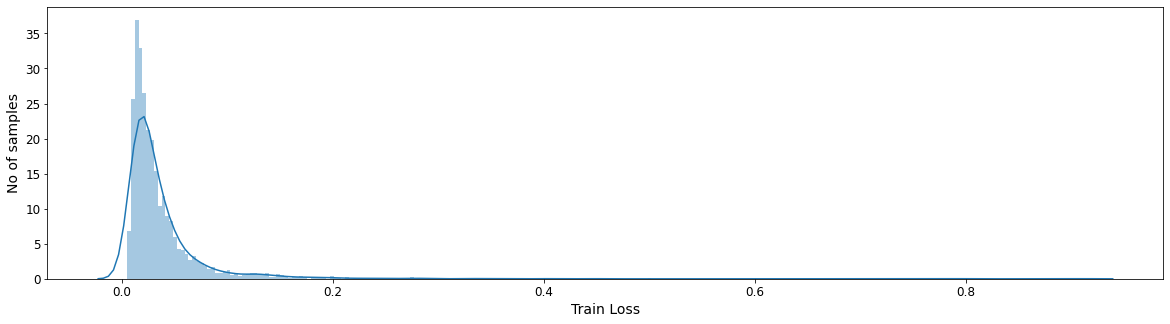

[INFO] Thresholds
------------------------------
CRITICAL: 0.295035


In [21]:
fig, ax = plt.subplots( figsize=(20, 5) )

sns.distplot(Train_Loss['Loss'], bins='auto', kde=True, ax=ax)
plt.xlabel("Train Loss", size = 14)
plt.ylabel("No of samples",  size = 14)
plt.xticks(size = 12);
plt.yticks(size = 12);
plt.show()

# Calculate threshold
#
WARNING  = np.quantile( Train_Loss['Loss'], 0.95 )
CRITICAL = np.quantile( Train_Loss['Loss'], 0.997 )

print('[INFO] Thresholds')
print(30*'-')
print("WARNING:  %.6f" % WARNING)
print("CRITICAL: %.6f" % CRITICAL)

In [22]:
def anomalyEvaluation(x):
    if (x < WARNING):
        return ('NORMAL')
    elif (x >= WARNING and x < CRITICAL):
        return ('WARNING')
    else:
        return ('CRITICAL')
    
# Detect all the samples which are anomalies (WARNING/CRITICAL)
#
Train_Loss['Status'] = Train_Loss['Loss'].apply( anomalyEvaluation )

Train_Loss['Status'].value_counts()

NORMAL      2495
WARNING      124
CRITICAL       8
Name: Status, dtype: int64

## Testing


### Calculate loss for testing set data

In [23]:
# Get test MAE loss.
test_losses = []
for data in tqdm( test_loader ):

        # Convert Double(float64) to Float(float32)
        #
        if (torch.cuda.is_available() == True):
            data = torch.tensor(data, dtype=torch.float32).cuda()
        else:
            data = torch.tensor(data, dtype=torch.float32)
 
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        _, _, outputs = model(data)
        
        
        # Calculate the loss
        #
        for dim in range( data.shape[0] ):
            test_losses.append( criterion(outputs[dim], data[dim]).item() )

test_losses = np.array(test_losses)  


# Create DataFrame with results(loss)
Test_Loss = pd.DataFrame( 
                          {
                            'Loss'            : test_losses
                          }
                        )

100%|██████████| 141/141 [00:00<00:00, 225.25it/s]


### Plot Loss-Histogram

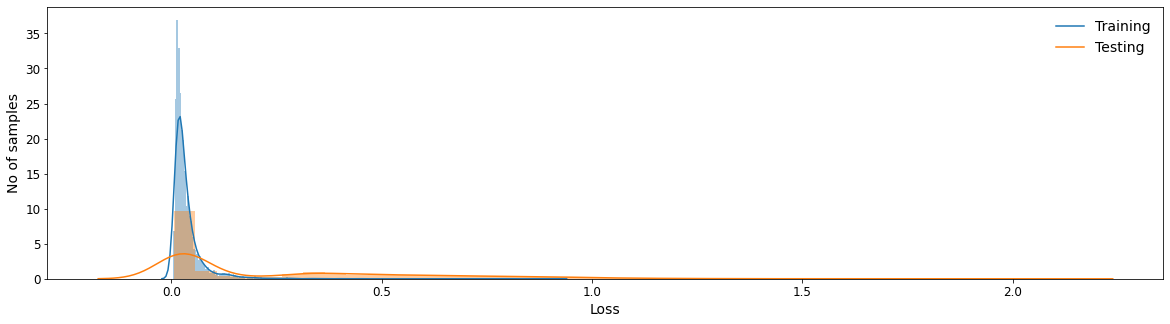

In [24]:
fig, ax = plt.subplots( figsize=(20, 5) )

sns.distplot(Train_Loss['Loss'], bins='auto', kde=True, ax=ax)
sns.distplot(Test_Loss['Loss'],  bins='auto', kde=True, ax=ax)


plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.xlabel("Loss", size = 14)
plt.ylabel("No of samples",  size = 14)
plt.xticks(size = 12);
plt.yticks(size = 12);

### Identify possible anomalies

In [25]:
# Detect all the samples which are anomalies (WARNING/CRITICAL)
#
Test_Loss['Status'] = Test_Loss['Loss'].apply( anomalyEvaluation )

Test_Loss['Status'].value_counts()

NORMAL      2496
CRITICAL    1723
WARNING      281
Name: Status, dtype: int64

### Classification evaluation

**Note:** The predicted as 'WARNING' cases by the prediction model are considered as 'NORMAL' in the classification evaluation

In [26]:
from sklearn.metrics import confusion_matrix

pred = Test_Loss['Status'].values
pred = np.where(pred != 'NORMAL', 'ANOMALY', 'NORMAL')
# pred = np.where(pred == 'CRITICAL', 'ANOMALY', 'NORMAL')

CM = confusion_matrix(testY, pred)

<AxesSubplot:>

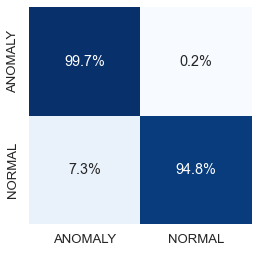

In [27]:
plt.figure( figsize = (4, 4) )
sns.set(font_scale = 1.2)

sns.heatmap(CM / np.sum(CM, axis=1), 
            annot=True, 
            xticklabels = ['ANOMALY','NORMAL'],
            yticklabels = ['ANOMALY','NORMAL'], 
            cbar = False,
            fmt='.1%', 
            cmap='Blues')

# Latent vectors study

In [28]:
op = []
for data in tqdm( test_loader ):

        # Convert Double(float64) to Float(float32)
        #
        if (torch.cuda.is_available() == True):
            data = torch.tensor(data, dtype=torch.float32).cuda()
        else:
            data = torch.tensor(data, dtype=torch.float32)
 
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        z = model.transform( data )

        # Store outputs
        #
        op += list( z.detach().cpu().numpy() )

        
# Convert to NumPy array
#
op = np.array( op )  

100%|██████████| 141/141 [00:00<00:00, 726.58it/s]


## Visualize latent space

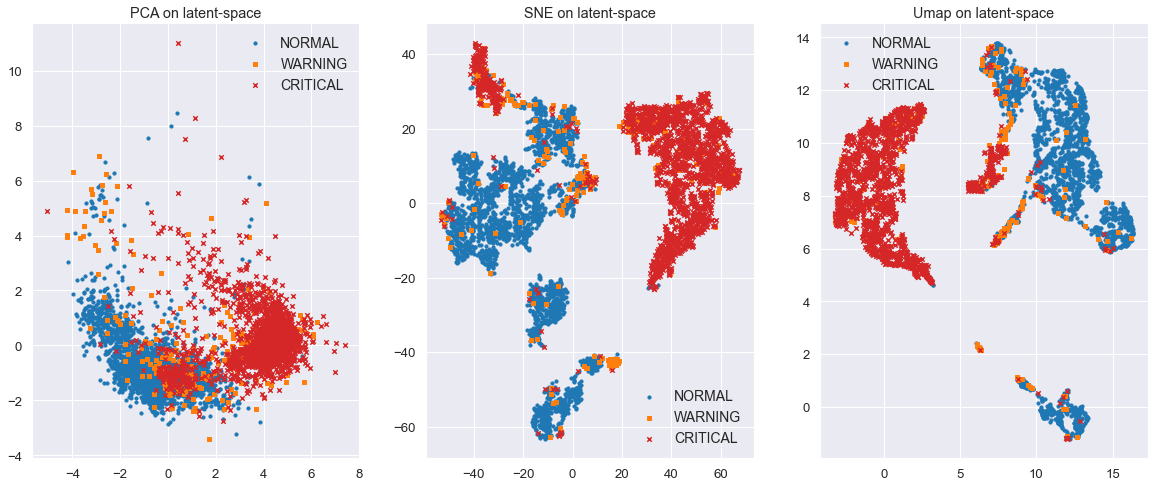

In [29]:
plot_latent_space(op, Test_Loss['Status'].values, figsize=(20, 8))

## Latent space analysis for Classification evaluation

In [30]:
import umap
#
embedding = umap.UMAP(n_neighbors = 30).fit_transform( op )

In [31]:
labels = []
for (x,y) in zip(pred, testY):
    if (x == y):
        if (x == 'NORMAL'):
            labels += ['TP']
        else:
            labels += ['TN']
    else:
        if (x == 'NORMAL'):
            labels += ['FP']
        else:
            labels += ['FN']

Text(0.5, 1.0, 'UMAP on latent-space - Confusion matrix')

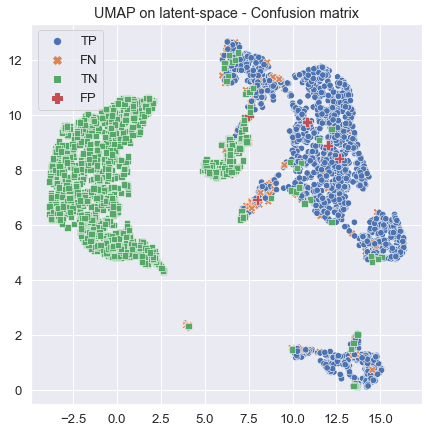

In [32]:
plt.figure( figsize = (7, 7))
sns.scatterplot(x = embedding[:, 0], 
                y = embedding[:, 1], 
                hue   = labels, 
                style = labels,
                size  = labels,
                legend = labels,
                sizes = (100, 40));

plt.title('UMAP on latent-space - Confusion matrix')

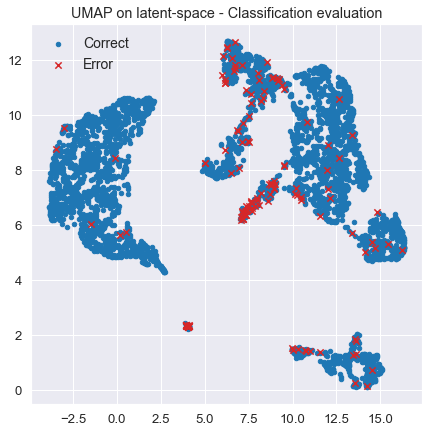

In [33]:
plt.figure( figsize = (7, 7) )

idx = np.where(pred == testY)
plt.scatter(embedding[idx, 0], embedding[idx, 1], marker='o', color='tab:blue', s = 20)
idx = np.where(pred != testY)
plt.scatter(embedding[idx, 0], embedding[idx, 1], marker='x', color='tab:red',  s = 40)

plt.title('UMAP on latent-space - Classification evaluation')
plt.legend(['Correct', 'Error'], frameon = False, fontsize = 14);